In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import data
import numpy as np
import yfinance as yf
from datetime import date, timedelta

In [3]:
symbol = "ROSSELLIND.NS"
start_time = date.today() - timedelta(days=40)
end_time = date.today()

In [4]:
fivemin = yf.download(symbol, interval='5m', start=start_time, end=end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
df = fivemin

In [6]:
# fivemin
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-15 09:15:00+05:30,148.250000,148.250000,148.250000,148.250000,148.250000,0
2022-03-15 09:20:00+05:30,148.550003,149.750000,148.550003,149.699997,149.699997,0
2022-03-15 09:25:00+05:30,148.850006,149.699997,148.550003,149.550003,149.550003,413
2022-03-15 09:30:00+05:30,149.050003,150.649994,149.050003,150.649994,150.649994,1833
2022-03-15 09:35:00+05:30,150.800003,153.600006,150.800003,152.949997,152.949997,2535


In [7]:
df['5ema'] = df['Close'].rolling(5).mean()

In [8]:
df = df.dropna()

In [9]:
# entry candle is the one which is above 5 ema and doesnt touch 5ema line.
df['entry_candle'] = np.nan
df.loc[(df['5ema'] < df['Low']), 'entry_candle'] = 1

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
# now we need to look for a candle which crosses the entry candle low, that will be the buy price.
df['signal'] = np.nan
df['buy_price'] = np.nan
df['sell_price'] = np.nan
entry_candle_index = -1
in_trade = False
length_of_signal_candle = -1
buy_price = -1
for idx in df.index:
    
    if not in_trade:
    # if we have found the entry candle and we arent in a trade
        if entry_candle_index != -1:
            if df['Low'][idx] < df['Low'][entry_candle_index]:
                df['signal'][idx] = 1
                length_of_signal_candle = df['High'][idx] - df['Low'][idx]
                buy_price = df['Low'][entry_candle_index]
                df['buy_price'][idx] = df['Low'][entry_candle_index]
                in_trade = True

        # find the entry candle, given we are not in any trade.
        if df['entry_candle'][idx] == 1:
            entry_candle_index = idx
        
    else:
        # if we are in a trade
        # either we hit SL
        if df['High'][idx] >= buy_price + length_of_signal_candle:
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            df['sell_price'][idx] = buy_price + length_of_signal_candle
            in_trade = False
        # or we hit the target.
        elif df['Low'][idx] >= buy_price - 2 * length_of_signal_candle:
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            df['sell_price'][idx] = buy_price - 2 * length_of_signal_candle
            in_trade = False
            
        

/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_15092/1722048099.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][idx] = 1
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_15092/1722048099.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['buy_price'][idx] = df['Low'][entry_candle_index]
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_15092/1722048099.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [11]:
df[(df.signal == 1) | (df.signal == -1)]

,Open,High,Low,Close,Adj Close,Volume,5ema,entry_candle,signal,buy_price,sell_price
Datetime,,,,,,,,,,,
2022-03-15 10:15:00+05:30,154.000000,154.899994,154.000000,154.399994,154.399994,1423,153.679999,1.0,1.0,154.050003,NaN
2022-03-15 10:20:00+05:30,154.399994,155.250000,154.000000,155.250000,155.250000,6367,154.289999,NaN,-1.0,NaN,-2.0
2022-03-15 10:40:00+05:30,155.699997,155.699997,154.699997,155.350006,155.350006,2027,155.450003,NaN,1.0,155.100006,NaN
2022-03-15 10:45:00+05:30,155.350006,155.550003,154.449997,154.899994,154.899994,724,155.380002,NaN,-1.0,NaN,1.0
2022-03-15 10:50:00+05:30,154.600006,154.899994,154.500000,154.800003,154.800003,245,155.220001,NaN,1.0,155.100006,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22 09:55:00+05:30,219.300003,219.800003,217.500000,219.800003,219.800003,6295,217.710004,NaN,1.0,221.100006,NaN
2022-04-22 10:00:00+05:30,219.550003,220.000000,217.000000,217.050003,217.050003,7280,217.860004,NaN,-1.0,NaN,1.0
2022-04-22 10:05:00+05:30,217.399994,217.800003,216.000000,217.300003,217.300003,6921,218.050003,NaN,1.0,221.100006,NaN


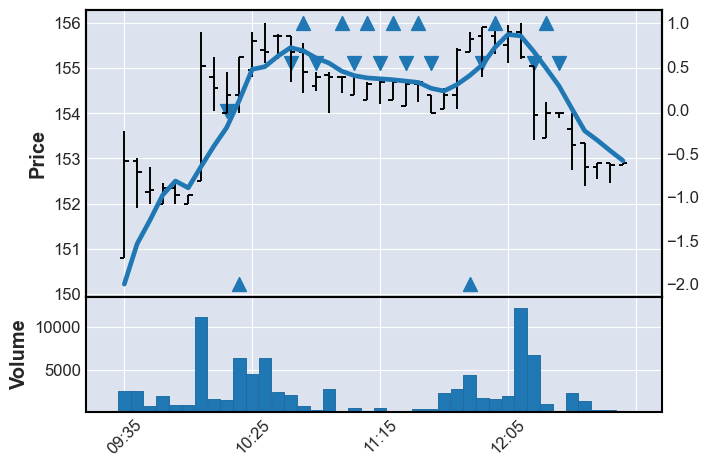

In [14]:
import mplfinance as mpf

def plot(df):
    apds = [
        mpf.make_addplot(df['5ema']),
#         mpf.make_addplot(df['signal'] ,type='scatter', markersize=100, marker='v'),
        mpf.make_addplot(df['buy_price'] ,type='scatter', markersize=100, marker='v'),
        mpf.make_addplot(df['sell_price'] ,type='scatter', markersize=100, marker='^')
    ]
    
    mpf.plot(df, volume=True, addplot=apds)
    
    
plot(df.head(40))